## Open Food Facts FOOD CSV quick scan

#### In this notebook i wanted to create a progressive and simple data analysis, to help me improving the data quality of my dataset before starting the vector step and ML training. The target data is the openfoodfacts dataset, with most of the useless column for the project dropped (images, duplicate column type, brands ...) in order for me to be able to process it


## Objectives

#### The objectives of this file is to do a quick scan and cleaning of the dataset, inside a panda dataframe. After that, the goal will be to make the dataset ML ready.

In [1]:
# ---- Config ----
from pathlib import Path

# Point to your local OFF food CSV (TAB-separated). Supports .csv or .csv.gz
OFF_PATH = Path("../data/openfoodfacts/openfoodfactsfull-clean.csv")

# Optional: only load a subset of columns (speeds up). Example:
USECOLS = []  # e.g.: ["code", "product_name", "brands", "countries", "nutriscore_grade"]

# Optional: limit rows for a quick scan. 0 = read all rows
LIMIT = 0

# How many top missing columns to display
TOPK = 25


### Function made to detect empty row data, error management that extract zip files if the dataset is compressed

In [2]:
# ---- Imports & helpers ----
import gzip
import pandas as pd
import numpy as np

EXTRA_MISS = {"", " ", "[]", "{}", "unknown", "UNKNOWN", "na", "NA", "null", "NULL"}

def open_csv(path: Path):
    if str(path).endswith(".gz"):
        return gzip.open(path, "rt", encoding="utf-8", errors="replace")
    return open(path, "r", encoding="utf-8", errors="replace")


### Here i want to see wich columns have the biggest amount of empty data, it helps me later to know what row and column to drop in order to concentrate data quality

In [3]:
# ---- Load & compute missing stats ----
if not OFF_PATH.exists():
    raise FileNotFoundError(f"Input file not found: {OFF_PATH.resolve()}")

usecols = [c.strip() for c in USECOLS if str(c).strip()] or None
nrows = LIMIT if (isinstance(LIMIT, int) and LIMIT > 0) else None

with open_csv(OFF_PATH) as f:
    df = pd.read_csv(
        f,
        sep=",",
        dtype="string",
        usecols=usecols,
        nrows=nrows,
        na_values=list(EXTRA_MISS),
        keep_default_na=True,
        low_memory=False,
    )

# Normalize blanks to NA (after stripping)
for c in df.columns:
    s = df[c]
    if pd.api.types.is_string_dtype(s):
        df[c] = s.str.strip().replace("", pd.NA)

total = len(df)
miss_counts = df.isna().sum()
miss_pct = (miss_counts / total * 100.0).round(1)

order = (
    pd.DataFrame({'column': df.columns, 'missing_count': miss_counts, 'missing_pct': miss_pct})
    .sort_values(['missing_pct', 'missing_count', 'column'], ascending=[False, False, True])
    .reset_index(drop=True)
)

print(f"rows: {total}")
print(f"columns: {df.shape[1]}")

print(f"\nTop {TOPK} columns by missing %:")
for _, r in order.head(int(TOPK)).iterrows():
    print(f"- {r['column']}: {int(r['missing_count'])} missing ({r['missing_pct']:.1f}%)")


rows: 259124
columns: 18

Top 25 columns by missing %:
- ingredients_tags: 89875 missing (34.7%)
- carbohydrates_100g: 0 missing (0.0%)
- created_datetime: 0 missing (0.0%)
- created_t: 0 missing (0.0%)
- energy-kcal_100g: 0 missing (0.0%)
- energy-kj_100g: 0 missing (0.0%)
- energy_100g: 0 missing (0.0%)
- fat_100g: 0 missing (0.0%)
- fiber_100g: 0 missing (0.0%)
- food_groups: 0 missing (0.0%)
- nutriscore_grade: 0 missing (0.0%)
- nutriscore_score: 0 missing (0.0%)
- product_name: 0 missing (0.0%)
- proteins_100g: 0 missing (0.0%)
- salt_100g: 0 missing (0.0%)
- saturated-fat_100g: 0 missing (0.0%)
- sodium_100g: 0 missing (0.0%)
- sugars_100g: 0 missing (0.0%)


## Preview of first 10 rows to see if everything is fine

In [4]:
# This cell shows the first 10 rows as a pandas DataFrame
df.head(10)

,created_datetime,product_name,food_groups,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,ingredients_tags,nutriscore_score,nutriscore_grade,created_t,energy-kj_100g,sodium_100g
0,2023-03-14T14:10:19Z,granola Bio le Chocolaté,en:dried-fruits,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"es:honig-stillende-frauen-nicht-geeignet,es:d-...",4,c,1678803019,0.0,0.0
1,2018-04-15T16:43:14Z,Madeleines ChocoLait,en:biscuits-and-cakes,460.0,1926.0,24.0,6.0,54.0,31.0,1.4,6.4,0.48,"en:wheat-flour,en:cereal,en:flour,en:wheat,en:...",20,e,1523810594,0.0,0.0
2,2021-02-28T15:18:57Z,Farandole de madeleine,en:biscuits-and-cakes,389.0,1630.0,16.7,6.48,35.2,1.85,18.5,37.0,0.88,"fr:madeleines-choconoir,fr:madeleines-nappees-...",9,c,1614525537,0.0,0.0
3,2022-11-25T13:40:30Z,Fanta Orange,en:biscuits-and-cakes,32.0,1917.0,0.0,0.0,7.7,7.6,0.0,0.0,0.02,en:69-while-mtr-waffel-mit-feiner-milchhaselnu...,7,c,1669383630,0.0,0.0
4,2018-09-19T14:22:43Z,Multi Patents Collagen Peptides,en:biscuits-and-cakes,350.0,1460.0,0.0,0.0,0.0,9.09,0.0,90.9,0.0,"en:multi-collagen-complex,en:hydrolyzed-bovine...",-1,a,1537366963,0.0,0.0
5,2016-12-01T19:59:24Z,Fondants Citron,en:sweets,249.0,1056.0,0.3,0.05,60.0,59.0,2.0,0.5,0.05,"en:blackberry,en:fruit,en:berries,en:cane-suga...",17,d,1480622364,0.0,0.0
6,2020-01-21T14:38:39Z,Abricots,en:dried-fruits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"en:apricot,en:fruit,en:prunus-species-fruit",-4,a,1579617519,0.0,0.0
7,2020-06-30T12:29:48Z,Confiture de fraise mara des bois,en:sweets,0.0,0.0,0.0,0.0,100.0,725.0,0.0,0.0,0.0,"en:e968,en:monk-fruit-extract,en:sweetener",15,d,1593520188,0.0,0.0
8,2021-08-30T11:04:53Z,Peanut Brittle,en:sweets,443.0,1867.0,3.9,2.5,72.1,51.5,1.9,7.7,0.0,"en:sugar,en:added-sugar,en:disaccharide,en:glu...",22,e,1630321493,0.0,0.0
9,2020-01-21T15:37:09Z,Dattes Mejdoul,en:dried-fruits,227.3,951.0,9.43,3.99,25.98,0.62,1.07,11.37,0.885,en:medjoul-dates,5,c,1579621029,0.0,0.0


## Print columns to see wich one i can ditch to make a better dataset 

In [5]:
# --- List all column names in the dataset ---
print("Total columns:", len(df.columns))
for c in df.columns:
    print(c)


Total columns: 18
created_datetime
product_name
food_groups
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
ingredients_tags
nutriscore_score
nutriscore_grade
created_t
energy-kj_100g
sodium_100g


#### Little barplot so i can see wich biggest amount of food type is in my new data

food_groups


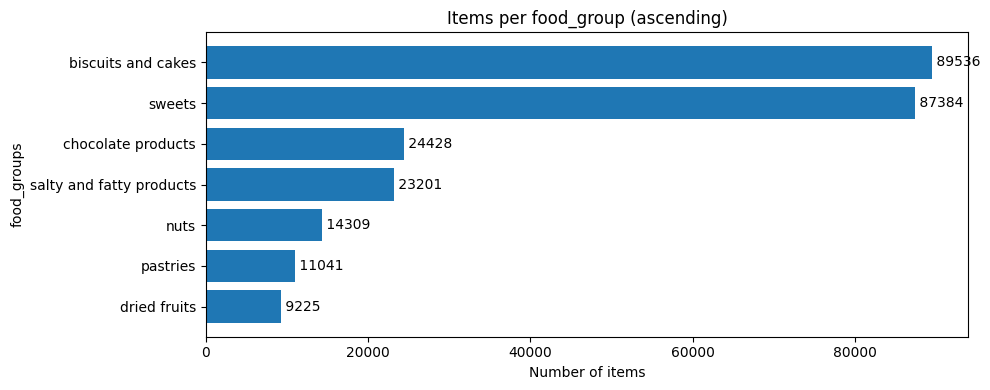

In [6]:
# --- Bar plot: count of items per food_group (ascending) ---

import re
import numpy as np
import matplotlib.pyplot as plt

COL = "food_groups"
print("food_groups")
if COL not in df.columns:
    raise KeyError(f"Column '{COL}' not found. Available: {list(df.columns)}")


# Prepare values
s = (
    df[COL]
      .dropna()
      .astype(str)
      .str.split(r"[|,]")        # split if multiple groups are packed
      .explode()
      .str.strip()
      .replace("", np.nan)
      .dropna()
      .str.lower()
      .str.replace(r"^[a-z]{2}:", "", regex=True)  # drop language prefix like 'en:'
      .str.replace("-", " ")
)

counts = s.value_counts().sort_values(ascending=True)

if counts.empty:
    print("No non-empty values in 'food_groups' to plot.")
else:
    # dynamic height so labels remain readable (cap to avoid huge figures)
    h = min(max(4, 0.25 * len(counts)), 18)
    plt.figure(figsize=(10, h))
    plt.barh(counts.index.astype(str), counts.values)
    plt.xlabel("Number of items")
    plt.ylabel("food_groups")
    plt.title("Items per food_group (ascending)")
    
    # annotate counts on bars
    for y, v in enumerate(counts.values):
        plt.text(v, y, f" {v}", va="center")
    
    plt.tight_layout()
    plt.show()


#### Same stuff for quick analysis of food components

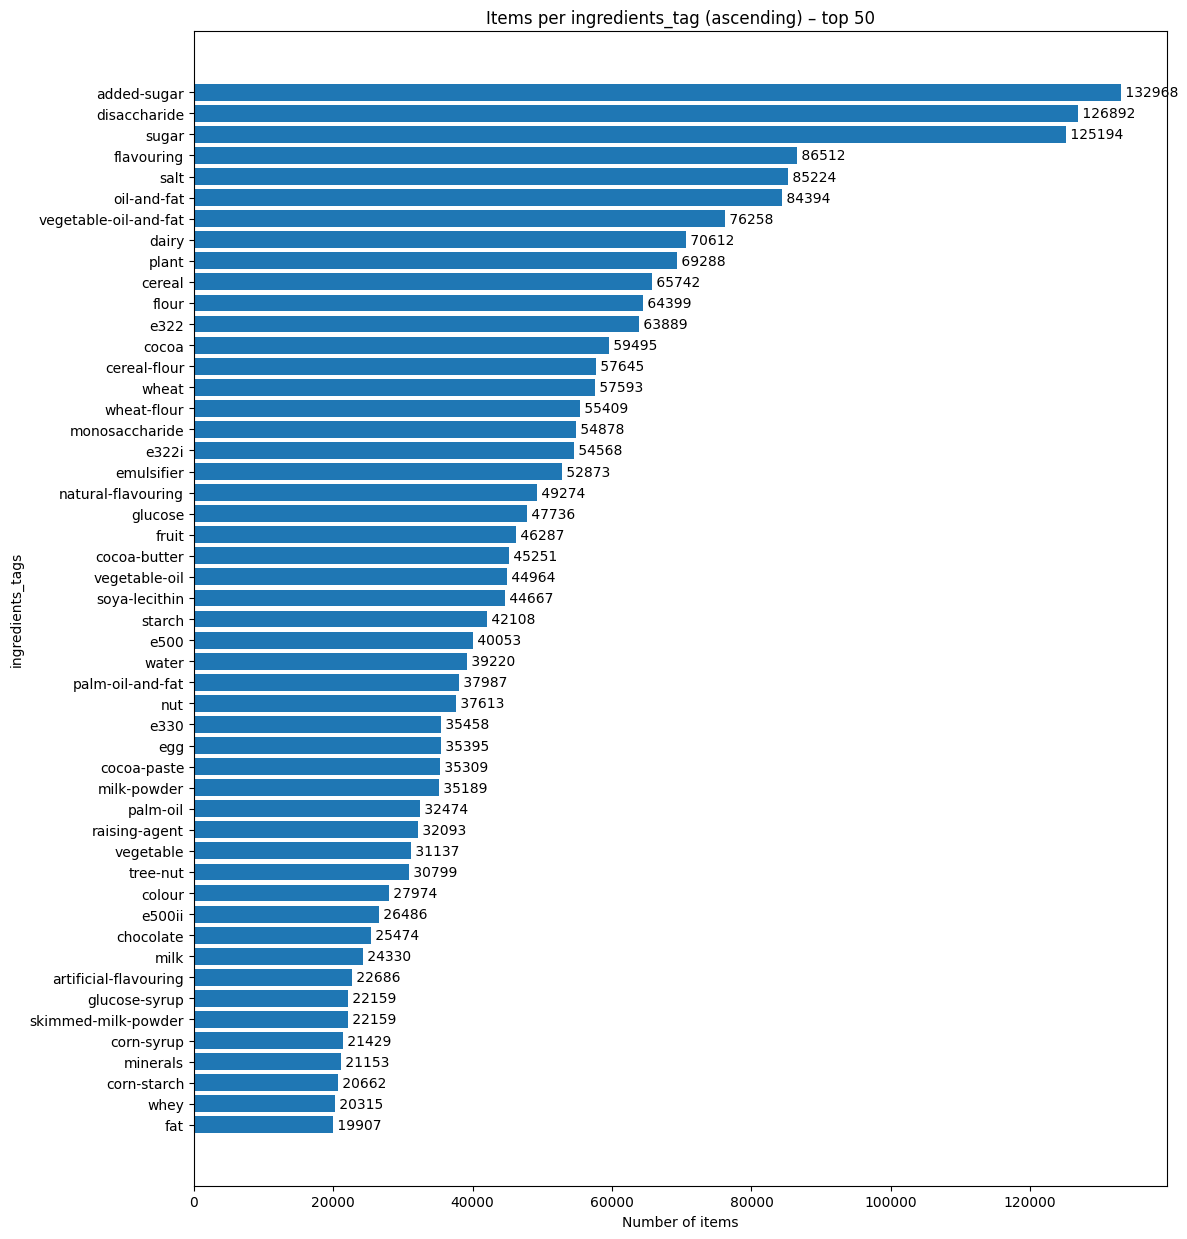

In [7]:
# --- Bar plot: count of items per ingredients_tag (ascending) ---

import numpy as np
import matplotlib.pyplot as plt
import re

COL = "ingredients_tags"   # OFF-style tag list, often like "en:sugar,en:wheat-flour,..."
TOP = 50                 # show top N tags (set to None to show all)

if COL not in df.columns:
    raise KeyError(f"Column '{COL}' not found. Available: {list(df.columns)}")

tags = (
    df[COL]
      .dropna()
      .astype(str)
      .str.split(r"[|,]")           # handle '|' or ',' separators
      .explode()
      .str.strip()
      .replace("", np.nan)
      .dropna()
      .str.lower()
      .str.replace(r"^[a-z]{2}:", "", regex=True)  # drop 'en:' / 'fr:' prefixes
)

counts = tags.value_counts()
if TOP:
    counts = counts.head(int(TOP))
counts = counts.sort_values(ascending=True)

if counts.empty:
    print("No non-empty values in 'ingredients_tags' to plot.")
else:
    height = min(max(4, 0.25 * len(counts)), 18)
    plt.figure(figsize=(12, height))
    plt.barh(counts.index.astype(str), counts.values)
    plt.xlabel("Number of items")
    plt.ylabel("ingredients_tags")
    plt.title(f"Items per ingredients_tag (ascending){' – top '+str(TOP) if TOP else ''}")

    for y, v in enumerate(counts.values):
        plt.text(v, y, f" {v}", va="center")

    plt.tight_layout()
    plt.show()
